In [10]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import (accuracy_score, precision_score,
                           recall_score, f1_score,
                           confusion_matrix, classification_report)
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize
import string
from sklearn.feature_extraction.text import CountVectorizer
import re
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [11]:
file_path = '/content/drive/MyDrive/Colab Notebooks/NLP/drugsComTest_raw.csv'
data = pd.read_csv(file_path, encoding='ISO-8859-1')

data.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount
0,163740,Mirtazapine,Depression,"""I&#039;ve tried a few antidepressants over th...",10,28-Feb-12,22
1,206473,Mesalamine,"Crohn's Disease, Maintenance","""My son has Crohn&#039;s disease and has done ...",8,17-May-09,17
2,159672,Bactrim,Urinary Tract Infection,"""Quick reduction of symptoms""",9,29-Sep-17,3
3,39293,Contrave,Weight Loss,"""Contrave combines drugs that were used for al...",9,5-Mar-17,35
4,97768,Cyclafem 1 / 35,Birth Control,"""I have been on this birth control for one cyc...",9,22-Oct-15,4


In [12]:
print("Missing values before cleaning:")
print(data[['review', 'rating']].isnull().sum())

data_cleaned = data.dropna(subset=['review', 'rating'])

print("\nMissing values after cleaning:")
print(data_cleaned[['review', 'rating']].isnull().sum())

print(f"\nRows removed: {len(data) - len(data_cleaned)}")
print("Final dataset size:", len(data_cleaned))

Missing values before cleaning:
review    0
rating    0
dtype: int64

Missing values after cleaning:
review    0
rating    0
dtype: int64

Rows removed: 0
Final dataset size: 53766


In [13]:
review_counts = data_cleaned['review'].count()
print(f"Number of reviews: {review_counts}")

Number of reviews: 53766


In [26]:
def categorize_sentiment(rating):
    """Categorizes review sentiment based on rating."""
    if rating >= 9:
        return 'Positive'
    elif 5 <= rating <= 8:
        return 'Neutral'
    elif 1 <= rating <= 4:
        return 'Negative'
    else:
        return 'Unknown'

In [40]:
print("Sample Positive Reviews:")
display(data_cleaned[data_cleaned['sentiment'] == 'Positive']['review'].head())

print("\nSample Neutral Reviews:")
display(data_cleaned[data_cleaned['sentiment'] == 'Neutral']['review'].head())

print("\nSample Negative Reviews:")
display(data_cleaned[data_cleaned['sentiment'] == 'Negative']['review'].head())

Sample Positive Reviews:


,review
0,"""I&#039;ve tried a few antidepressants over th..."
2,"""Quick reduction of symptoms"""
3,"""Contrave combines drugs that were used for al..."
4,"""I have been on this birth control for one cyc..."
7,"""This has been great for me. I&#039;ve been on..."



Sample Neutral Reviews:


,review
1,"""My son has Crohn&#039;s disease and has done ..."
6,"""I&#039;ve had the copper coil for about 3 mon..."
8,"""Ive been on Methadone for over ten years and ..."
11,"""Honestly its day one on the 3 day treatment. ..."
18,"""This medication helped me sleep, but eventua..."



Sample Negative Reviews:


,review
5,"""4 days in on first 2 weeks. Using on arms an..."
9,"""I was on this pill for almost two years. It d..."
10,"""Holy Hell is exactly how I feel. I had been t..."
12,"""This is a waste of money. Did not curb my ap..."
14,"""Ditto on rebound sleepless when discontinued...."


In [33]:
sentiment_distribution = data_cleaned['sentiment'].value_counts()
print("Sentiment Distribution:")
print(sentiment_distribution)

Sentiment Distribution:
sentiment
Positive    26193
Neutral     14076
Negative    13497
Name: count, dtype: int64


In [20]:

def preprocess_text(text):
    # Check if the input is a string
    if not isinstance(text, str):
        return ""
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Tokenize
    tokens = word_tokenize(text)
    # Remove stop words and lemmatize
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    processed_tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    # Join tokens back into a string
    return ' '.join(processed_tokens)

data_cleaned['processed_review'] = data_cleaned['review'].apply(preprocess_text)

print("Original Review Sample:")
display(data_cleaned['review'].head())
print("\nProcessed Review Sample:")
display(data_cleaned['processed_review'].head())

Original Review Sample:


,review
0,"""I&#039;ve tried a few antidepressants over th..."
1,"""My son has Crohn&#039;s disease and has done ..."
2,"""Quick reduction of symptoms"""
3,"""Contrave combines drugs that were used for al..."
4,"""I have been on this birth control for one cyc..."



Processed Review Sample:


,processed_review
0,i039ve tried antidepressant year citalopram fl...
1,son crohn039s disease done well asacol complai...
2,quick reduction symptom
3,contrave combine drug used alcohol smoking opi...
4,birth control one cycle reading review type si...


In [34]:
X = data_cleaned['processed_review']
y = data_cleaned['sentiment']

print("Features (X) sample:")
display(X.head())
print("\nTarget (y) sample:")
display(y.head())

Features (X) sample:


,processed_review
0,i039ve tried antidepressant year citalopram fl...
1,son crohn039s disease done well asacol complai...
2,quick reduction symptom
3,contrave combine drug used alcohol smoking opi...
4,birth control one cycle reading review type si...



Target (y) sample:


,sentiment
0,Positive
1,Neutral
2,Positive
3,Positive
4,Positive


In [65]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=45)

In [66]:
vectorizer = CountVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

In [67]:
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train_vectorized, y_train)

MultinomialNB()

In [68]:
y_pred = nb_classifier.predict(X_test_vectorized)

accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(accuracy)
print(classification_rep)

0.6380881532453041
              precision    recall  f1-score   support

    Negative       0.65      0.61      0.63      2649
     Neutral       0.48      0.39      0.43      2833
    Positive       0.69      0.79      0.74      5272

    accuracy                           0.64     10754
   macro avg       0.61      0.59      0.60     10754
weighted avg       0.63      0.64      0.63     10754



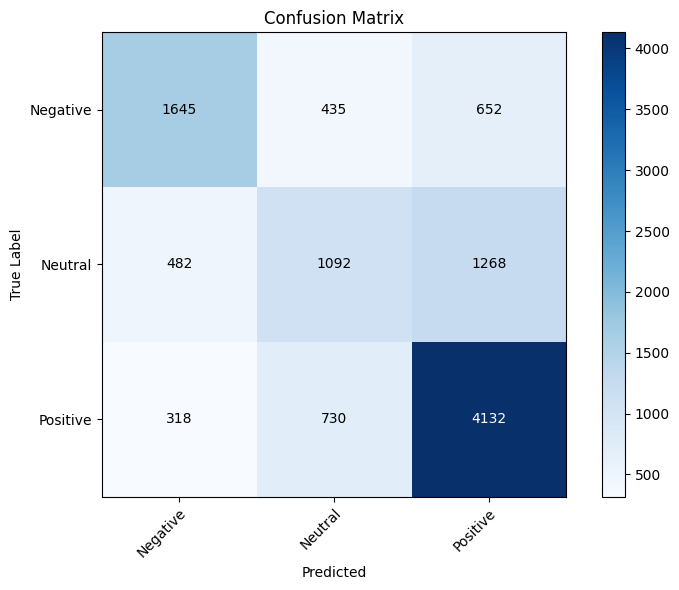

In [39]:
cm = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)

ax.set(
    xticks=np.arange(cm.shape[1]),
    yticks=np.arange(cm.shape[0]),
    xticklabels=nb_classifier.classes_,
    yticklabels=nb_classifier.classes_,
    title='Confusion Matrix',
    ylabel='True Label',
    xlabel='Predicted'
)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

fmt = 'd'
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(
            j, i, format(cm[i, j], fmt),
            ha="center", va="center",
            color="white" if cm[i, j] > thresh else "black"
        )

fig.tight_layout()
plt.show()